### Interpolate from 1/16 deg to 1/32 deg (HMIX=20)

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import warnings
warnings.filterwarnings("ignore")

In [3]:
orig = 'nw2_0.0625deg_N15_baseline_hmix20'
dest = 'nw2_0.03125deg_N15_baseline_hmix20'

path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'

# geometries
g0625 = xr.open_dataset(path+orig+'/ocean_geometry.nc', decode_times=False)
# run g125 from scratch for one time step to create ocean_geometry
g0312 = xr.open_dataset(path+dest+'/ocean_geometry.nc', decode_times=False)
# low res spun up (latests snaptho file)
snap_0625 = xr.open_dataset(path+orig+'/snapshots_00005505.nc',
                           decode_times=False)

In [4]:
# rename dims for interpolation
g0312 = g0312.rename({'lath':'yh', 'lonh':'xh'})
g0312

<xarray.Dataset>
Dimensions:  (yh: 4480, xh: 1920, latq: 4481, lonq: 1921)
Coordinates:
  * yh       (yh) float64 -69.98 -69.95 -69.92 -69.89 ... 69.92 69.95 69.98
  * xh       (xh) float64 0.01562 0.04688 0.07812 0.1094 ... 59.92 59.95 59.98
  * latq     (latq) float64 -70.0 -69.97 -69.94 -69.91 ... 69.94 69.97 70.0
  * lonq     (lonq) float64 0.0 0.03125 0.0625 0.09375 ... 59.94 59.97 60.0
Data variables: (12/19)
    geolatb  (latq, lonq) float64 ...
    geolonb  (latq, lonq) float64 ...
    geolat   (yh, xh) float64 ...
    geolon   (yh, xh) float64 ...
    D        (yh, xh) float64 ...
    f        (latq, lonq) float64 ...
    ...       ...
    dyBu     (latq, lonq) float64 ...
    Ah       (yh, xh) float64 ...
    Aq       (latq, lonq) float64 ...
    dxCvo    (latq, xh) float64 ...
    dyCuo    (yh, lonq) float64 ...
    wet      (yh, xh) float64 ...
Attributes:
    filename:  ./ocean_geometry.nc

### Create new dataset for the 1/8 case with modified xh and yh

In [5]:
xh = snap_0625.xh.values
xh[0] = xh[0]-1/8
xh[-1] = xh[-1]+1/8
yh = snap_0625.yh.values
yh[0] = yh[0]-1/8
yh[-1] = yh[-1]+1/8
zi = snap_0625.zi.values
time = np.array([snap_0625.time[-1]])
eta = snap_0625.e[-1,:].values

In [6]:
shape = time.shape + eta.shape

In [7]:
th1 = xr.Dataset(data_vars={"eta":(['time','zi','yh', 'xh'],np.zeros(shape)),}, 
                coords={"xh": xh, 
                        "yh": yh, 
                        'zi': zi,
                        'time': time})

In [8]:
th1.eta[0,:] = eta
th1 = th1.fillna(0)

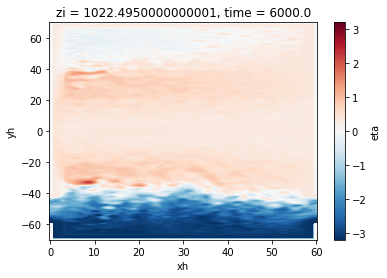

In [9]:
th1.eta[0,0,:].plot()

In [11]:
# interpolation
th_dest = th1.interp(xh=g0312.xh, yh=g0312.yh)

### Compare original and interpolated data

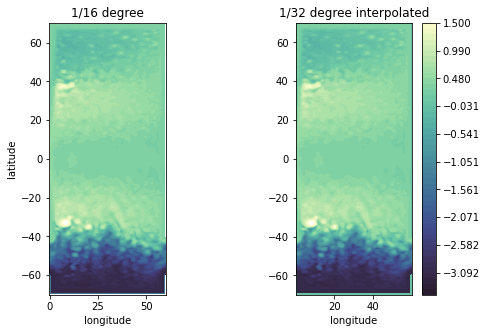

In [13]:
levs = np.linspace(-3.5,1.5,50)
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.contourf(snap_0625.xh,snap_0625.yh,snap_0625.e[-1,0], cmap=cmocean.cm.deep_r,levels=levs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('1/16 degree')
plt.subplot(1,2,2)
plt.contourf(th_dest.xh,th_dest.yh,th_dest.eta[0,0], cmap=cmocean.cm.deep_r,levels=levs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude')
plt.title('1/32 degree interpolated')
plt.colorbar()

In [14]:
th_dest = th_dest.fillna(0)
th_dest.to_netcdf(path+dest+'/INPUT/'+dest+'_eta.nc')

### Run the 1/32 case and load the initial conditions

In [15]:
ic = xr.open_mfdataset(path+dest+'/MOM_IC*.nc', decode_times=False)

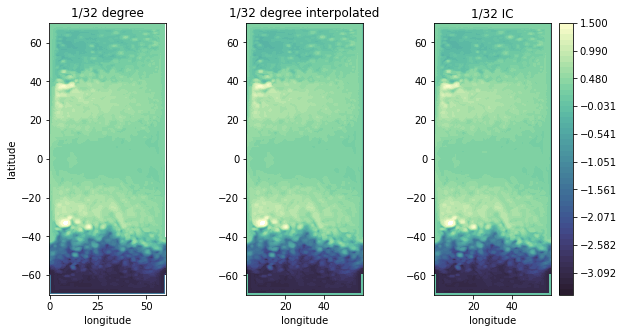

In [17]:
# compare eta original, interpolated and from IC
levs = np.linspace(-3.5,1.5,50)
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.contourf(snap_0625.xh,snap_0625.yh,snap_0625.e[-1,0], cmap=cmocean.cm.deep_r,levels=levs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('1/32 degree')
plt.subplot(1,3,2)
plt.contourf(th_dest.xh,th_dest.yh,th_dest.eta[0,0], cmap=cmocean.cm.deep_r,levels=levs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude')
plt.title('1/32 degree interpolated')
plt.subplot(1,3,3)
plt.contourf(ic.lonh,ic.lath,ic.eta[0,0], cmap=cmocean.cm.deep_r,levels=levs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude')
plt.title('1/32 IC')
plt.colorbar()

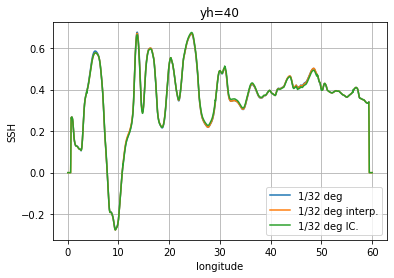

In [18]:
plt.figure()
plt.plot(snap_0625.xh,snap_0625.sel(yh=40, method='nearest').e[-1,0], label='1/32 deg')
plt.plot(th_dest.xh,th_dest.sel(yh=40, method='nearest').eta[0,0], label='1/32 deg interp.')
plt.plot(ic.lonh,ic.sel(lath=40, method='nearest').eta[0,0], label='1/32 deg IC.')
plt.legend()
plt.title('yh=40')
plt.xlabel('longitude')
plt.ylabel('SSH')
plt.grid()

Text(0.5, 1.0, 'yh=-50')

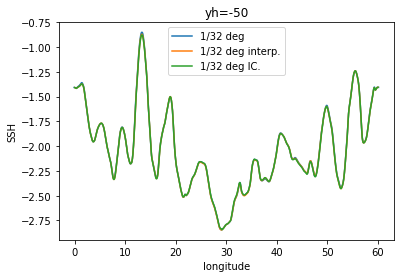

In [20]:
plt.figure()
plt.plot(snap_0625.xh,snap_0625.sel(yh=-50, method='nearest').e[-1,0], label='1/32 deg')
plt.plot(th_dest.xh,th_dest.sel(yh=-50, method='nearest').eta[0,0], label='1/32 deg interp.')
plt.plot(ic.lonh,ic.sel(lath=-50, method='nearest').eta[0,0], label='1/32 deg IC.')
plt.legend()
plt.xlabel('longitude')
plt.ylabel('SSH')
plt.title('yh=-50')